# Elevator simulation


In [0]:
# Necessary imports
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

# (Global Variable) that is a flag for Verbose argument that 
# will print detailed results.
VERBOSE_FLAG = False 

## Elevator class

In [0]:
class Elevator(object):

    """
    Elevator class. 
    
    Attributes included:
      + max_capacity: The max number of people the elevator can take at a time
      + total_time: The total time of movement of elevator
      + floors: The tumple containing bottom and top floors.
      + population: The tuple containing all the passengers
      + passenger_served: The total number of passengers this elevator has served so far
      + current_floor: Current location of the elevator
      + request_queue: A list of lists containing passengers waiting at each level
            The passengers are indexed by their origin.
      + direction: The direction of movement of the elevator
      + move_cost: The time of moving the elevator by single floor
      + pickup_cost: The time of loading or unloading a single passenger
      + current_num_passengers: The number of total passenger currently in the elevator
      + current_passengers: list of list containing passengers in the elevator
           The passengers are arranged in list with index equal to their destination
      + next_passenger_index: The index of the next passenger to pickup in the
           population tuple.


    Methods included:
      + __init__(): to initiate the attributes
      + move(): Move the elevator based on the floor number provided
      + take_passenger(): Load one passenger into the elevator from current floor
      + off_passenger(): Offload one passenger
      + open_doors(): Unload and load relevant passengers
      + pass_time(): Adds given time to the total time taken of elevator
    """

    def __init__(self, floors, population, max_capacity=10, 
                 current_floor=0, move_cost=5, pickup_cost=2):
        '''
        Initialize Elevator class with default parameter settings
        
        Inputs:
        
        * floors (tuple) A tuple consisting the value of bottom floor and top 
        floor. Default: None. [Required parameter]
        
        * population (tuple) A tuple containing tuples that include a passenger
        object and his/her arrival time. Default: None. [Required parameter]
        
        * max_capacity (int)  The maximum carrying capacity of the elevator.
        Default: 10
        
        * current_floor (int)  The floor the elevator is currently staying in.
        Default: 0
        
        * move_cost (int)  The time cost or time taken for moving the elevator 
        by one floor. Default: 5
        
        * pickup_cost (int)  The time taken to load or offload one passenger
        into the elevator. Default: 2
        '''
        
        self.max_capacity = max_capacity
        self.total_time = 0
        self.floors = floors
        self.population = population
        self.passenger_served = 0
        self.current_floor = current_floor
        self.request_queue = [[] for _ in range(self.floors[0], self.floors[1] + 1)]
        
        self.direction = None 
        # True is going up, False is going down, None is not moving
        
        self.move_cost = move_cost
        self.pickup_cost = pickup_cost
        self.current_num_passengers = 0
        self.current_passengers = [[] for _ in range(self.floors[0], self.floors[1] + 1)]
        self.next_passenger_index = 0

    def move(self,floor):
        '''
            Moves the elevator by to the given floor
            
            Inputs:
            * floor (int) The destination floor that the elevator needs to go
            [Required parameter]
        '''
        floor_diff = floor - self.current_floor
        if VERBOSE_FLAG:
            print("ELEVATOR MOVED TO: ", floor) 
        self.pass_time(self.move_cost*abs(floor_diff))
        self.current_floor = floor

    def take_passenger(self):
        '''
           Loads one passenger waiting in the current floor 
        '''
        
        # Gets the first element in the request queue
        passenger = self.request_queue[self.current_floor].pop(0)

        if VERBOSE_FLAG:
            print("LOADED: ", passenger)
        
        passenger.set_pick_up_time(self.total_time)
        
        self.current_passengers[passenger.destination].append(passenger)
        # Add the passenger to list indexed to his/her destination
        # in current_passengers list
        
        self.pass_time(self.pickup_cost)
        self.current_num_passengers += 1
        self.direction = passenger.direction

    def off_passenger(self):
        '''
            Offloads one passenger from current floor
        '''
        passenger = self.current_passengers[self.current_floor].pop(0)
        if VERBOSE_FLAG:
            print("OFFLOADED: ", passenger)
        passenger.set_dest_arrival_time(self.total_time)
        self.passenger_served += 1
        self.pass_time(self.pickup_cost)
        self.current_num_passengers -= 1
        
        if self.current_num_passengers == 0:
            self.direction = None
        
    def open_doors(self):
        '''
        First offloads all the passenger in the elevator with destination as 
        current floor then, Loads passengers from current floor until the 
        elevator is full, if direction fits
        '''
        for i in range(len(self.current_passengers[self.current_floor])):
            self.off_passenger()
        relevant_passengers = [p for p in self.request_queue[self.current_floor]
                               if p.direction == self.direction or self.direction == None]
        load = min(self.max_capacity - self.current_num_passengers, len(relevant_passengers))
        # Finding number of passenger to load in the elevator
        
        for i in range(load):
            self.take_passenger()
            
    def pass_time(self,time):
        '''
        Passes time or adds time passed to the total time.
        
        Input:
        
        * time (int) Time taken for a certain action to be added to the total_time
          attribute. [Required Parameter]
          
        '''
        self.total_time += time
        self.update_request_queue()
        
    def update_request_queue(self):
        '''
        Updates the request queue. It loads the passenger who have already
        arrived (arrival_time > total_time) to the request queue for being
        picked up.
        
        '''
        if self.next_passenger_index >= len(self.population):
            return
        
        while self.population[self.next_passenger_index][0].arrival_time <= self.total_time:
            new_passenger = self.population[self.next_passenger_index][0]
            if VERBOSE_FLAG:
                print("ADDED TO QUEUE: ", new_passenger, "arrived at", new_passenger.arrival_time)
            self.request_queue[new_passenger.origin].append(new_passenger)
            self.next_passenger_index += 1
            if self.next_passenger_index >= len(self.population):
                return

## Passenger class

In [0]:
class Passenger(object):
  
    '''
    Passenger class: need to take in the number of floors defined by the user

    Attributes:
    + origin: origin floor number
    + destination: destination floor
    + arrival_time: The time when the person arrives and starts waiting for elevator
    + direction: direction of the passenger (True means going up)
    + pick_up_time: The time when the passenger moves in the elevator
    + dest_arrival_time: The time when the passenger stops at the elevator

    Method:
    get_origin_location(): return the origin location of the passenger
    get_destination(): return the destination of the passenger
    set_pick_up_time(): sets pick_up_time to given time
    set_dest_arrival_time(): sets dest_arrival_time to given time

    '''

    def __init__(self, origin=None, destination=None, arrival_time = 0):
        '''
        Initializes passenger class with default parameter settings

        Inputs:

        * origin(int): The floor where passenger starts his/her ride.
          Default: None. [Required parameter]

        * destination(int): The destination floor where passenger wants to go.
          Default: None [Required parameter]

        * arrival_time(int): The time when passengers arrives to the elevator in seconds.
          Default: 0 [Optional parameter]
        '''
        
        # Raising error if origin or destination have not been passed.
        if origin != None:
            self.origin = origin
        else:
            raise Exception('Passenger destination have not been defined')
        if destination != None:
            self.destination = destination
        else:
            raise Exception('Passenger destination have not been defined')
        
        
        # Initializing other variables
        self.arrival_time = arrival_time 
        self.pick_up_time = None # Time when the person gets into elevator
        self.dest_arrival_time = None # Time when the person reaches destination
        self.direction = True if self.origin < self.destination else False

    def get_origin(self):
        '''
        Returns the origin floor number of passenger
        '''
        return self.origin

    def get_destination(self):
        '''
        Returns the destination floor number of passenger
        '''
        return self.destination
      
    def __repr__(self):
        return "{}->{}".format(self.origin, self.destination)
      
    def set_pick_up_time(self, time):
        '''
        Sets the pick_up_time when the passenger is picked up by elevator
        '''
        self.pick_up_time = time
    

    def set_dest_arrival_time(self, time):
        '''
        Sets the destination arrival time when the passenger is offloaded
        '''
        self.dest_arrival_time = time
        

## Building class

In [0]:
class BuildingType(Enum):
    '''
        Two types of building.
        
         1 is for a residential building, where the distribution of passenger origins
        and destinations is skewed towards the ground floor
        
        2 is for a mall complex, where the distribution is closer to uniform
    '''
    RESIDENTIAL = 1
    MALL = 2

class Building(object):
  
    """
    Building class
    Attributes: 
    + max_floors: The maximum number of floors in the building
    + num_passengers: The starting number of passengers in the building
    
    
    Methods:
    + initiate
    + generate_passengers: Generates passengers and keeps them in a request queue for the elevator
    + generate_elevator: Generates the elevator
    """

    def __init__(self, floors = (0,10), num_passenger = 10, building_type = BuildingType.RESIDENTIAL, rush_hours=[8,12,18]):
        '''
        Initialize the Building class with default values
        
        Inputs:
        
        * floors (tuple) The bottom and top floor of the building 
          Default:(0, 10)
        
        * num_passengers (int) The number of passengers to be transported
          Default: 10
        
        * building_type (Enum) The type of building. 
          Default: BuildingType.RESIDENTIAL
        
        * rush_hours (list) The rush hours when there will be more passengers
        
        '''
        self.num_passenger = num_passenger
        self.building_type = building_type
        self.rush_hours = rush_hours
        self.floors = floors
        self.population = self.generate_passengers() 
        # Generating new passengers
        
    def generate_passengers(self):
        '''
        Generates the passenger in the building based on type of building
        
        Output:
        
        * a (tuple) of tuples that include each passenger and arrival time
            sorted in the ascending order of arrival time
        
        '''

        passengers = []
        total_floors = self.floors[1] - self.floors[0] + 1
        
        if self.building_type == BuildingType.RESIDENTIAL:
            # Assumption here is that for res hall, 
            # the resquest from & to ground floor is 20 times higher
            prob = [20] + [1]*(total_floors - 1)
        elif self.building_type == BuildingType.MALL:
            # For mall complex, passenger can move around floors more uniformly
            prob = [1] * (0 - self.floors[0]) + [3] + [1]*(self.floors[1])
        
        prob /= np.sum(prob) # Normalizing probability to 1
        
        # Time initialization
        # Assumption: simulate a day, with rush hours are defined in self.rush_hours
        # Passenger arrival time is defined in second
        
        # Defining different probability of getting times based on rush hours
        time_prob = []
        if self.rush_hours == []:
            time_prob = [1]*86400
        else:
            time_prob = [1]*3600*self.rush_hours[0]
            time_prob += [3]*3600
            for i in range(1,len(self.rush_hours)):
                time_prob += [1]*3600*(self.rush_hours[i] - self.rush_hours[i-1] -1)
                time_prob += [3]*3600
        time_prob += [1]*3600*(24-self.rush_hours[len(self.rush_hours)-1]-1)
        time_prob /= np.sum(time_prob)
            
        for p in range(self.num_passenger):          
            origin, destination = np.random.choice(np.arange(self.floors[0], 
                                                             self.floors[1] + 1),
                                                   size=2, p=prob)
            arrival_time = np.random.choice(np.arange(86400), p=time_prob)

            while origin == destination:
                # Re-choosing the origin and destination if they have same 
                # origin and destination
                origin, destination = np.random.choice(np.arange(self.floors[0],
                                                                 self.floors[1] + 1), 
                                                       size=2, p=prob)
            
            passenger = Passenger(origin, destination, arrival_time)
            passengers.append((passenger, arrival_time))
        
        passengers.sort(key=lambda tup: tup[1])
            
        return passengers
    
    def generate_elevator(self):
        '''
        Generates a new elevator for the building
        
        Ouptut:
        
        * elevator (object) an instance of Elevator class
        
        '''
        elevator = Elevator(floors = self.floors, 
                            population = self.population)
        return elevator
    
    
    def calculate_results(self):
        '''
        
        Calculates the average waiting time for passenger, average time moving
        in elevator and average journey time (combining both waiting and 
        destination time). Prints detailes report of each passenger if
        VERBOSE_FLAG is True.
        
        Output:
        * (tuple) including
            * 'avg_waiting_time' (float) the average time that each passenger 
               waits for the elevator before he/she rides it
            * 'avg_movement_time' (float) the average time that each passenger 
               rides the elevator
            * 'avg_journey_time' (float) the average time taken for each
               passenger to travel including the waiting time 
               
        '''
        
        total_waiting_time = 0
        total_movement_time = 0
        total_journey_time = 0
        
        if VERBOSE_FLAG:
            print('***'*20)
            print ('Arrival Time    Pickup Time    Destination Arrival Time')

        for p in self.population:
            # Calculate and add different times for each passenger
            if VERBOSE_FLAG:
                print(p[0].arrival_time, '\t\t', p[0].pick_up_time, '\t\t', 
                      p[0].dest_arrival_time)
            total_waiting_time += (p[0].pick_up_time - p[0].arrival_time)
            total_movement_time += (p[0].dest_arrival_time - p[0].pick_up_time)
            total_journey_time += (p[0].dest_arrival_time - p[0].arrival_time)
            
        # Calculating average for each metric
        avg_waiting_time = total_waiting_time/self.num_passenger
        avg_movement_time = total_movement_time/self.num_passenger
        avg_journey_time = total_journey_time/self.num_passenger
        
        if VERBOSE_FLAG:
            print('Average waiting time: ', avg_waiting_time)
            print('Average movement time: ', avg_movement_time)
            print('Average journey time: ', avg_journey_time)

        return (avg_waiting_time, avg_movement_time, avg_journey_time)   
    
    def simulate(self, strategy):
        '''
        
        Simulates the elevator motion based on the strategy passed
        
        Input:
        * strategy (function) The strategy used for finding the next destination
          of the elevator
        
        Output (from 'calculate_results' function):
        * (tuple) including
            * 'avg_waiting_time' (float) the average time that each passenger 
               waits for the elevator before he/she rides it
            * 'avg_movement_time' (float) the average time that each passenger 
               rides the elevator
            * 'avg_journey_time' (float) the average time taken for each
               passenger to travel including the waiting time 
        '''
        
        print('--'*20)
        print('Simulation started')

        self.elevator = self.generate_elevator() #generating elevator
        
        for i in range(100000):
            self.elevator.update_request_queue()
            if any(self.elevator.request_queue) or self.elevator.current_num_passengers != 0:
                self.elevator.open_doors()
                # get the next destination based on the strategy
                next_move = strategy(self.elevator)
                if next_move != None:
                    if VERBOSE_FLAG:
                        passengers_inside = []
                        for floor in self.elevator.current_passengers:
                            for p in floor:
                                passengers_inside.append(p)
                        print_request_queue(self.elevator.request_queue, 
                                            self.elevator.current_floor, 
                                            self.elevator.floors, 
                                            passengers_inside,
                                            next_move)   
                    self.elevator.move(next_move)
                else:
                    self.elevator.pass_time(1)
            else:
                self.elevator.pass_time(1)
         
        print('Simulation ended')
        print('--'*20)
        return self.calculate_results()


In [0]:
def print_request_queue(q, elevator_floor, floors, current_passengers, next_move=None):
    '''
        Prints detailed current position of elevator and passengers
        
        Input:
        
        * q (list) of list that contains the request_queue with all waiting
          passengers
          
        * elevator_floor (num) the current floor of the elevator
        
        * floors (tuple) Bottom and top floor of the building/elevator
        
        * current_passengers (list) includes all the passengers currently in
          elevator
        
        * next_move (int) The next destination of the elevator. Default: None
        
    '''
    print("CURRENT BUILDING STATE:")
    for floor, passengers in enumerate(q[::-1]):
        string = str(floors[1] - floor) + " -- " + str(passengers)
        if elevator_floor == floors[0] + floors[1] - floor:
            string += " 🚪({}) ".format(current_passengers)
        if next_move == floors[0] + floors[1] - floor:
            string += "<-- suggested floor"
        print(string)

## Strategies 

### Naive strategy

In [0]:
def naive_strategy(elevator):
    '''
        Uses the naive strategy: The elevator moves on floor at a time and stops
        at every floor.
        
        Input:
         
        * elevator (object) an instance of Elevator class
        
        Output:
        
        * (int) next destination of the elevator

    '''

    if elevator.current_floor < elevator.floors[0]:
        raise Exception('Elevator is below lowest floor')

    if elevator.current_floor == elevator.floors[0]:
        # Move up if the elevator is in bottom floor
        elevator.temp_direction = True
        return elevator.floors[0] + 1    
    elif elevator.current_floor == elevator.floors[1]:
        # Move down if the elevator is at top floor.
        elevator.temp_direction = False
        return elevator.floors[1] - 1    
    else:
        # If elevator is in the middle floors based on its direction, it will 
        # move one floor up or down
        if elevator.temp_direction == True:
            return elevator.current_floor + 1
        else:

            return elevator.current_floor - 1

In [0]:
# Testing naive strategy
building  = Building(num_passenger=5, floors=(0, 5))
print(building.population)
VERBOSE_FLAG = True
building.simulate(naive_strategy)

### Smart strategy

In [0]:
def smart_strategy(elevator):
    '''
    Uses the smarter strategy: The elevator only moves and stops at floors 
    where there are passengers waiting or that are destination of current
    passenger in the elevator. If there are passengers inside, it will determine
    the direction of elevator and only move and pick up passengers in that 
    direction. If there is no one inside, it will go to closest request.


    Input:

    * elevator (object) an instance of Elevator class

    
    Output:

    * (int) next destination of the elevator

    '''
    if elevator.current_floor < elevator.floors[0]:
        raise Exception('Elevator is below lowest floor')
    
    closest_offload = None 
    if elevator.direction is not None:
        # Someone is inside an elevator and elevator is moving
        closest_offload = find_closest_offload(elevator)
            # nearest destination of the passenger in the elevator
    
    closest_request = find_closest_request(elevator)
    # nearest floor in which passenger is waiting
    
    if closest_offload is None:
        return closest_request
    elif closest_request is None:
        return closest_offload
    
    func = min if elevator.direction else max
    return func(closest_request, closest_offload)

def find_closest_offload(elevator):
    '''
    Finds the nearest destination of the passengers currently in the elevator
    
    Input:
    
    * elevator (object) an instance of Elevator class
    
    
    Output:
    * (int) the floor number of nearest destination
    
    '''
    
    current_passengers = elevator.current_passengers
    floors = elevator.floors
    current_floor = elevator.current_floor
    direction = elevator.direction
    
    closest = None
    if direction:
        # Going up
        closest = floors[1] + 1
        func = min
    else:
        closest = -1
        func = max
    
    for floor in current_passengers:
        for p in floor:
            # find the closest destination for each passenger in each floor
            # Double loop required because current_passenger is list of list 
            # where passengers are kept inside the list with same index as their
            # destination
            if p.direction == direction:
                closest = func(closest, p.destination)
    
    if closest >= floors[0] and closest <= floors[1]:
        return closest

def find_closest_request(elevator):
    '''
    Finds the nearest destination where the passenger is waiting for elevator
    
    Input:
    
    * elevator (object) an instance of Elevator class
    
    
    Output:
    * (int) the floor number of nearest destination
    
    '''
    request_queue = elevator.request_queue
    floors = elevator.floors
    current_floor = elevator.current_floor
    direction = elevator.direction
    
    # Check the passenger going in same direction as the elevator
    shift = 1 if direction else -1 
    floor = current_floor + shift
    while floor >= floors[0] and floor <= floors[1]:
        for p in request_queue[floor]:
            if p.direction == direction or direction is None:
                return floor
        floor += shift
    
    # No passengers going in the same direction as an elevator
    # Look for other requests (in a different direction)
    shift = -shift # change the direction 
    floor = current_floor + shift # Start looking from the current floor
    while floor >= floors[0] and floor <= floors[1]:
        for p in request_queue[floor]:
            if p.direction == direction or direction is None:
                return floor
        floor += shift
    return None


In [0]:
# Testing the smarter strategy
building  = Building(num_passenger=5, floors=(0, 5))
print(building.population)
VERBOSE_FLAG = True

building.simulate(smart_strategy)

In [0]:
# Testing the smart strategy on MALL building type
building  = Building(num_passenger=5, floors=(0, 5), building_type = BuildingType.MALL)
print(building.population)
VERBOSE_FLAG = True

building.simulate(smart_strategy)

## Comparing strategies

In [0]:
def test_simulations(num_simulations=10, 
                     floors = (0,10), 
                     num_passenger = 10, 
                     building_type = BuildingType.RESIDENTIAL, 
                     rush_hours=[8,12,18]):
    
    '''
    Simulates the simulation using both naive and smart strategy
    
    Input:
    
    * num_simulations (int) The number of simulations to run. Default: 10
    
    * floors (tuple) The bottom and top floor of building. Default: (0, 10)
    
    * num_passenger (int) Number of passenger in the building. Default:10
    
    * building_type (Enum) The type of building. Default: BuildingType.RESIDENTIAL
    
    * rush_hours (list) The rush hours with high passenger flow. 
      Default:[8,12,18]
      
      
    Output:
    * (tuple) of (tuples), The tuples includes the results for each metric
      for naive strategy and smart strategy for each simulation
      Metrics are average waiting time, average movement time and average 
      journey time.
    '''
    
    # Arrays to store metric for naive strategies
    wait_time_naive = []
    move_time_naive = []
    journey_time_naive = []
    
    # Arrays to store metric for smart strategy
    wait_time_smart = []
    move_time_smart = []
    journey_time_smart = []

    np.random.seed(100)

    VERBOSE_FLAG = False

    for i in range(num_simulations):

        b1 = Building(floors = floors, 
                      num_passenger = num_passenger, 
                      building_type = building_type, 
                      rush_hours=rush_hours)
        wait_naive, move_naive, journey_naive = b1.simulate(naive_strategy)
        wait_time_naive.append(wait_naive)
        move_time_naive.append(move_naive)
        journey_time_naive.append(journey_naive)

        b2 = Building(floors = floors, 
                      num_passenger = num_passenger, 
                      building_type = building_type, 
                      rush_hours=rush_hours)
        wait_smart, move_smart, journey_smart = b2.simulate(smart_strategy)
        wait_time_smart.append(wait_smart)
        move_time_smart.append(move_smart)
        journey_time_smart.append(journey_smart)
        
    return((wait_time_naive, move_time_naive, journey_time_naive),
           (wait_time_smart, move_time_smart, journey_time_smart)
          )
        
def plot_hist(smart_arr, naive_arr,
              metric=None,
              num_floor=None,
              num_passengers=None, 
              building_type=None):
    '''
    Plots joint histogram of two arrays which are results for simulaiton for 
    smart and naive strategy.
    
    Input:
    
    * smart_arr (list) results of simulation for smart strategy
    
    * naive_arr (list) results of simulation for naive strategy
    
    * metric (string) The name of metrics used
    
    * num_floor (int) Number of floors in the building
    
    * num_passengers (int) Number of passengers in the building
    
    '''
    plt.hist(smart_arr, alpha=0.6,bins=20, histtype="bar", rwidth=0.9, label="Smart strategy")
    plt.hist(naive_arr, alpha=0.6,bins=20, histtype="bar", rwidth=0.9, label="Naive strategy")
    plt.suptitle("Histogram of {0} for smart and naive strategies".format(metric))
    plt.title("# of floors - {}, # of passengers - {}, {} ".format(num_floor,num_passengers, building_type))
    plt.xlabel("Time taken")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def display_hist(num_floor, num_passengers, building_type, results_smart, results_naive):
    '''
    Displays comparative histograms for each metric between smart and naive
    strategy. 

    Input:
        
    * num_floor (int) Number of floors in the building
    
    * num_passengers (int) Number of passengers in the building
    
    * results_smart (tuple) of lists that includes all results from the simulation
      for smart strategy
    
    * results_naive (tuple) of lists that includes all results from the simulation
      for naive strategy
    '''
    plot_hist(results_smart[0], results_naive[0], 
              metric="waiting time",
              num_floor=num_floor,
              num_passengers=num_passengers, 
              building_type=building_type)
    plot_hist(results_smart[1], results_naive[1],
              metric="movement time",
              num_floor=num_floor,
              num_passengers=num_passengers, 
              building_type=building_type)
    plot_hist(results_smart[2], results_naive[2],
              metric="journey time",
              num_floor=num_floor,
              num_passengers=num_passengers, 
              building_type=building_type)

### Residential building

In [0]:
VERBOSE_FLAG=False
# Comparing for residential building
num_passengers = 50
floors = (0,10)
num_floor = floors[1] - floors[0] + 1

(results_naive, results_smart) = test_simulations(100, floors, num_passengers)

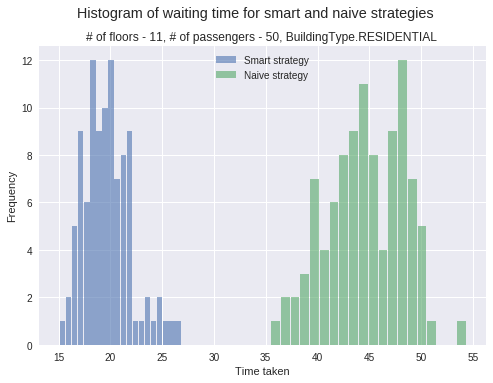

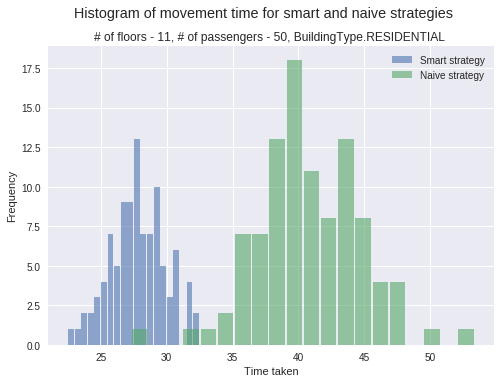

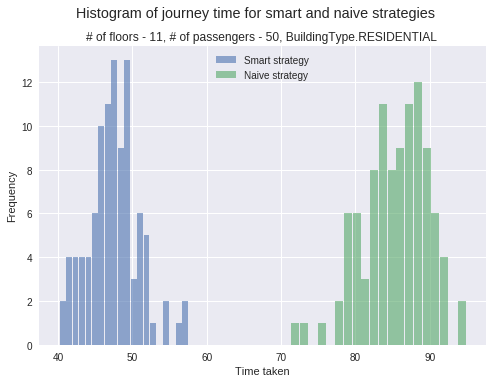

In [0]:
#Graphs for analysis
display_hist(num_floor, num_passengers, BuildingType.RESIDENTIAL, results_smart, results_naive)

### Mall complex 

In [0]:
# Comparing strategies for MALL building type
num_passengers = 10
floors = (0, 5)
num_floor = floors[1] - floors[0] + 1
np.random.seed(6)
(results_naive, results_smart) = test_simulations(20, floors, num_passengers,
                                                  BuildingType.MALL)

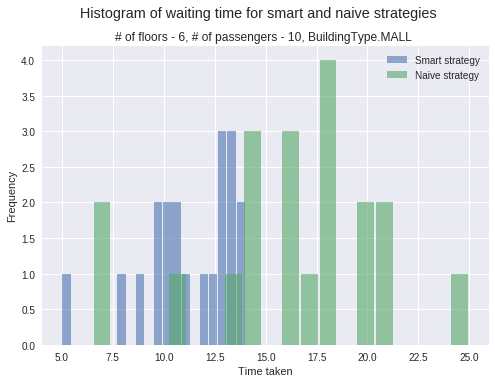

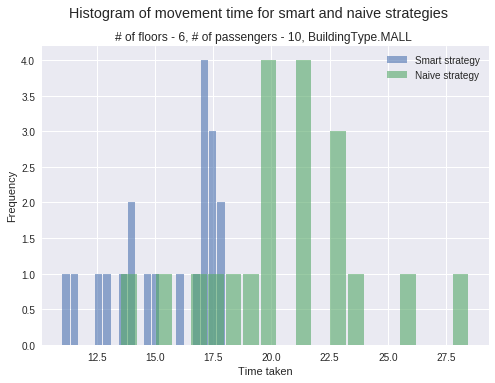

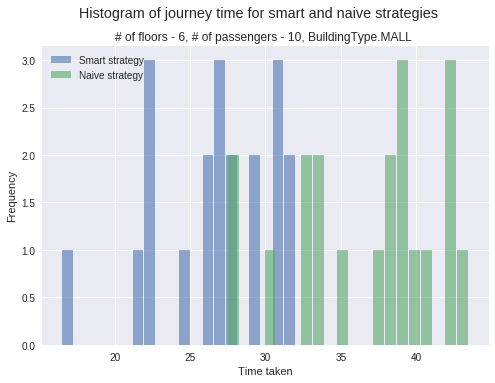

In [0]:
#Graphs for analysis
display_hist(num_floor, num_passengers, BuildingType.MALL, results_smart, results_naive)